# PKSmart Phase 1 Model Validation Report

이 리포트는 PKSmart 모델의 성능을 논문 기준 지표(R², RMSE, GMFE, Fold Errors)를 통해 검증하고 시각화합니다.

### 검증 대상 엔드포인트
- **CL (Clearance)**: 약물 제거율
- **VDss (Volume of Distribution at Steady-state)**: 정체 상태에서의 분포 용적
- **fup (Fraction Unbound in Plasma)**: 혈장 내 비결합 분율
- **MRT (Mean Residence Time)**: 평균 체류 시간
- **t1/2 (Half-life)**: 반감기

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = ".."
sys.path.append(PROJECT_ROOT)
sys.path.append(os.path.join(PROJECT_ROOT, "validation"))

from pksmart.models import PKSmartPipeline
from validation_utils import (eval_regression_metrics, plot_pred_vs_true, 
                               plot_fold_error_hist, plot_cumulative_fold_error, 
                               plot_residual, plot_feature_importance)

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['font.family'] = 'AppleGothic'

## 1. 데이터 및 모델 로드

`data/Human_PK_data.csv`를 사용하여 학습된 모델의 재현율과 정확성을 확인합니다.

In [2]:
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "Human_PK_data.csv")
MODEL_DIR = os.path.join(PROJECT_ROOT, "models")

df_raw = pd.read_csv(DATA_PATH)
print(f"로드된 데이터 행 수: {len(df_raw)}")

# SMILES가 유효한 데이터만 사용
df = df_raw.dropna(subset=['smiles_r']).reset_index(drop=True)
print(f"유효한 SMILES 데이터 수: {len(df)}")

# 파이프라인 초기화
pipeline = PKSmartPipeline(MODEL_DIR)

로드된 데이터 행 수: 1283
유효한 SMILES 데이터 수: 1283


## 2. 예측 수행

전체 데이터셋에 대해 5가지 인간 PK 수치를 예측합니다. (이 과정은 Mordred 디스크립터 계산으로 인해 시간이 다소 소요될 수 있습니다.)

In [3]:
from pksmart.features import generate_features

print("특징 생성 중 (Morgan + Mordred)...")
features_df = generate_features(df['smiles_r'].tolist())

print("인간 PK 예측 수행 중...")
preds_df = pipeline.run_pipeline(features_df)
preds_df = preds_df.add_suffix("_pred")

# 결과 결합
results = pd.concat([df, preds_df], axis=1)

DEBUG: LOADING LOCAL FEATURES.PY
특징 생성 중 (Morgan + Mordred)...


[00:30:49] Initializing MetalDisconnector
[00:30:49] Running MetalDisconnector
[00:30:49] Initializing Normalizer
[00:30:49] Running Normalizer
[00:30:49] Initializing MetalDisconnector
[00:30:49] Running MetalDisconnector
[00:30:49] Initializing Normalizer
[00:30:49] Running Normalizer
[00:30:49] Running LargestFragmentChooser
[00:30:49] Running Uncharger
[00:30:49] Removed negative charge.
[00:30:49] Removed negative charge.
[00:30:49] Initializing MetalDisconnector
[00:30:49] Running MetalDisconnector
[00:30:49] Initializing Normalizer
[00:30:49] Running Normalizer
[00:30:49] Initializing MetalDisconnector
[00:30:49] Running MetalDisconnector
[00:30:49] Initializing Normalizer
[00:30:49] Running Normalizer
[00:30:49] Running LargestFragmentChooser
[00:30:49] Running Uncharger
[00:30:49] Removed negative charge.
[00:30:49] Initializing MetalDisconnector
[00:30:49] Running MetalDisconnector
[00:30:49] Initializing Normalizer
[00:30:49] Running Normalizer
[00:30:49] Initializing MetalD

Calculating Morgan Fingerprints...


[00:30:55] DEPRECATION WARNING: please use MorganGenerator
[00:30:55] DEPRECATION WARNING: please use MorganGenerator
[00:30:55] DEPRECATION WARNING: please use MorganGenerator
[00:30:55] DEPRECATION WARNING: please use MorganGenerator
[00:30:55] DEPRECATION WARNING: please use MorganGenerator
[00:30:55] DEPRECATION WARNING: please use MorganGenerator
[00:30:55] DEPRECATION WARNING: please use MorganGenerator
[00:30:55] DEPRECATION WARNING: please use MorganGenerator
[00:30:55] DEPRECATION WARNING: please use MorganGenerator
[00:30:55] DEPRECATION WARNING: please use MorganGenerator
[00:30:55] DEPRECATION WARNING: please use MorganGenerator
[00:30:55] DEPRECATION WARNING: please use MorganGenerator
[00:30:55] DEPRECATION WARNING: please use MorganGenerator
[00:30:55] DEPRECATION WARNING: please use MorganGenerator
[00:30:55] DEPRECATION WARNING: please use MorganGenerator
[00:30:55] DEPRECATION WARNING: please use MorganGenerator
[00:30:55] DEPRECATION WARNING: please use MorganGenerat

Calculating Mordred Descriptors...
  Computing Mordred descriptors (batch mode)...
    Processing Mordred for mol 0/1283
    Processing Mordred for mol 100/1283
    Processing Mordred for mol 200/1283
    Processing Mordred for mol 300/1283
    Processing Mordred for mol 400/1283
    Processing Mordred for mol 500/1283
    Processing Mordred for mol 600/1283
    Processing Mordred for mol 700/1283
    Processing Mordred for mol 800/1283
    Processing Mordred for mol 900/1283
    Processing Mordred for mol 1000/1283
    Processing Mordred for mol 1100/1283
    Processing Mordred for mol 1200/1283
인간 PK 예측 수행 중...


/Users/admin/Downloads/PKSmart_Phase1_Backup/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:641: UserWarning: Skipping features without any observed values: ['MAXsLi' 'MAXssBe' 'MAXssssBe' 'MAXssBH' 'MAXssssB' 'MAXddC' 'MAXsNH3'
 'MAXssNH2' 'MAXsssNH' 'MAXsSiH3' 'MAXssSiH2' 'MAXsssSiH' 'MAXssssSi'
 'MAXsPH2' 'MAXssPH' 'MAXsssP' 'MAXsssssP' 'MAXdS' 'MAXdssS' 'MAXsGeH3'
 'MAXssGeH2' 'MAXsssGeH' 'MAXssssGe' 'MAXsAsH2' 'MAXssAsH' 'MAXsssAs'
 'MAXsssdAs' 'MAXsssssAs' 'MAXsSeH' 'MAXdSe' 'MAXssSe' 'MAXaaSe'
 'MAXdssSe' 'MAXddssSe' 'MAXsSnH3' 'MAXssSnH2' 'MAXsssSnH' 'MAXssssSn'
 'MAXsPbH3' 'MAXssPbH2' 'MAXsssPbH' 'MAXssssPb' 'MINsLi' 'MINssBe'
 'MINssssBe' 'MINssBH' 'MINssssB' 'MINddC' 'MINsNH3' 'MINssNH2' 'MINsssNH'
 'MINsSiH3' 'MINssSiH2' 'MINsssSiH' 'MINssssSi' 'MINsPH2' 'MINssPH'
 'MINsssP' 'MINsssssP' 'MINdS' 'MINdssS' 'MINsGeH3' 'MINssGeH2'
 'MINsssGeH' 'MINssssGe' 'MINsAsH2' 'MINssAsH' 'MINsssAs' 'MINsssdAs'
 'MINsssssAs' 'MINsSeH' 'MINdSe' 'MINssSe' 'MINaaSe' 'MINdssSe'
 'M

## 3. 성능 검증 및 시각화

각 엔드포인트별로 논문 기준 지표를 산출하고 그래프를 그립니다.

/var/folders/fm/wsr26cj176bfqph7s7tp_sdc0000gn/T/ipykernel_7191/3121116705.py:55: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/admin/Downloads/PKSmart_Phase1_Backup/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


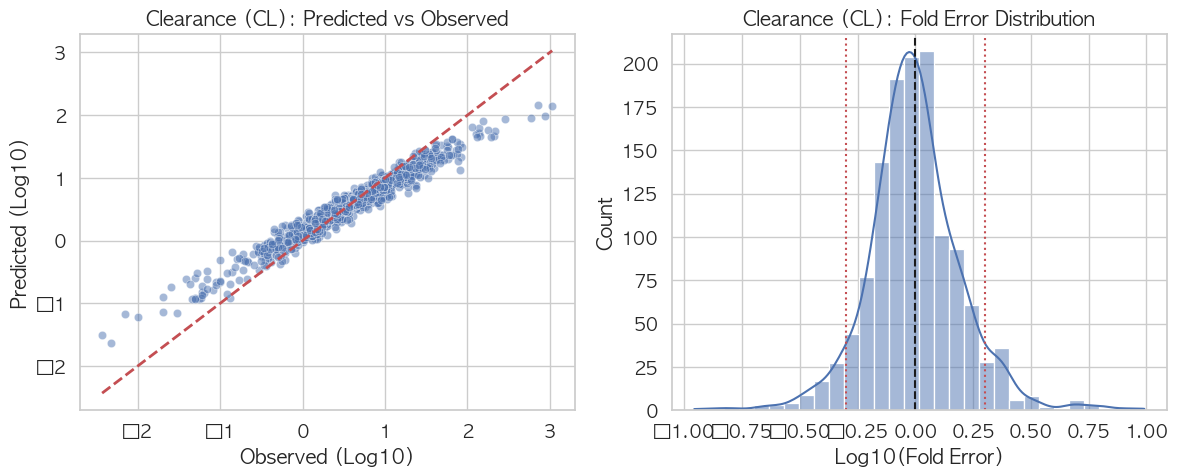

/var/folders/fm/wsr26cj176bfqph7s7tp_sdc0000gn/T/ipykernel_7191/3121116705.py:55: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/admin/Downloads/PKSmart_Phase1_Backup/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


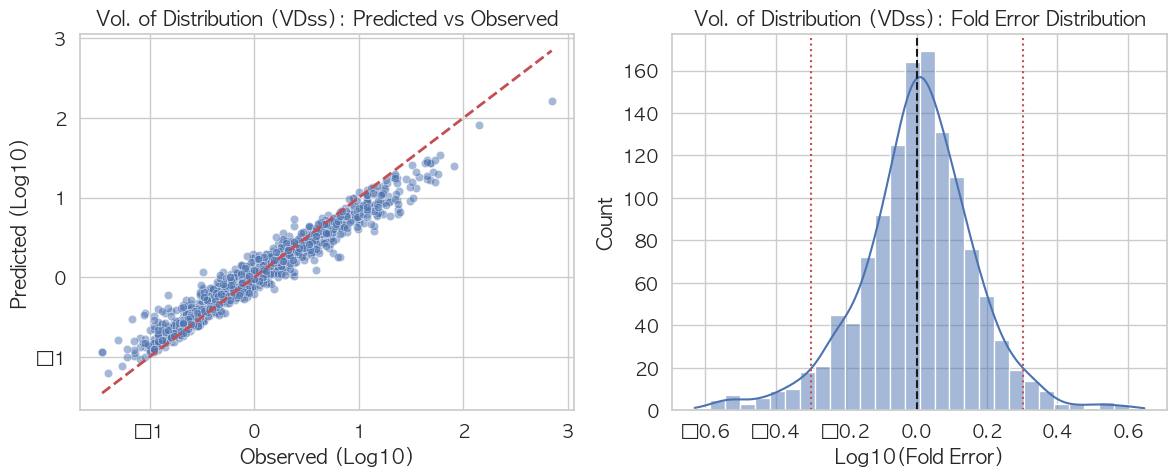

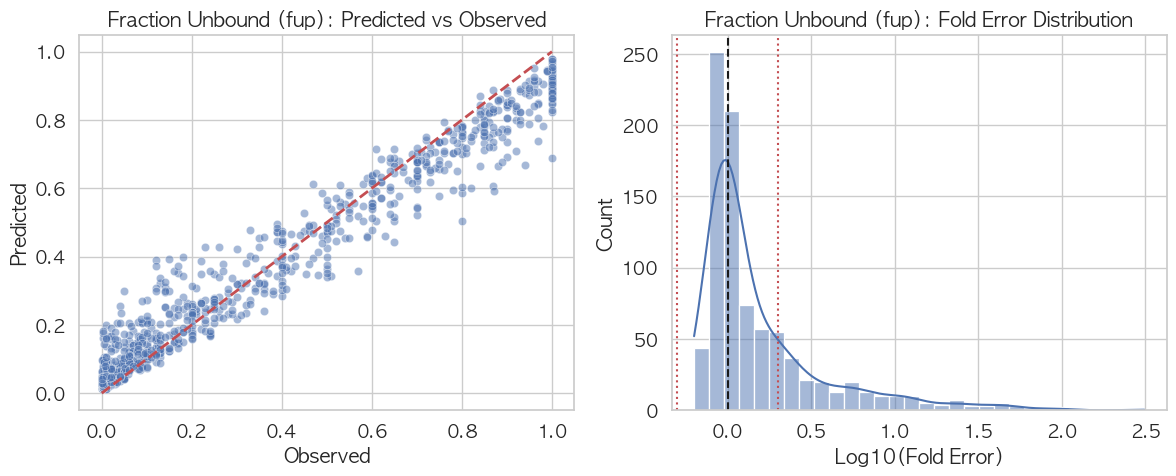

/var/folders/fm/wsr26cj176bfqph7s7tp_sdc0000gn/T/ipykernel_7191/3121116705.py:55: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/admin/Downloads/PKSmart_Phase1_Backup/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


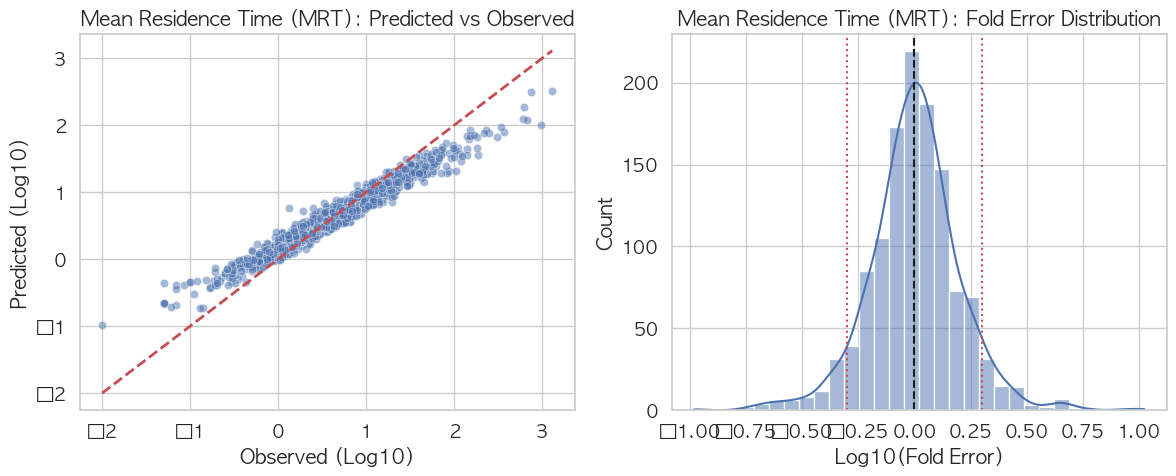

/var/folders/fm/wsr26cj176bfqph7s7tp_sdc0000gn/T/ipykernel_7191/3121116705.py:55: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/admin/Downloads/PKSmart_Phase1_Backup/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


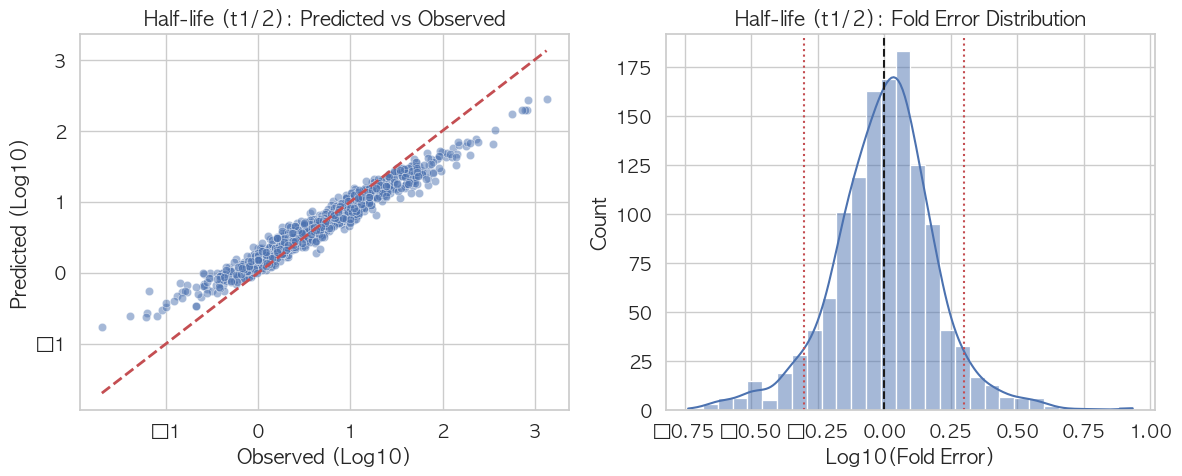

,R2,RMSE,GMFE,within_2fold_%,within_3fold_%,within_5fold_%,bias_median
Endpoint,,,,,,,
Clearance (CL),0.901597,0.203534,1.404421,87.900078,96.721311,98.985168,-0.127642
Vol. of Distribution (VDss),0.932682,0.166014,1.326426,92.473979,98.158527,100.000000,0.010351
Fraction Unbound (fup),0.945395,0.079630,1.737765,75.767918,84.300341,88.964733,0.010847
Mean Residence Time (MRT),0.900380,0.202555,1.406244,88.254224,96.942880,99.436846,0.020593
Half-life (t1/2),0.901140,0.195902,1.397163,88.616601,96.442688,99.604743,0.059007


In [4]:
endpoints = {
    "human_CL_mL_min_kg": "Clearance (CL)",
    "human_VDss_L_kg": "Vol. of Distribution (VDss)",
    "human_fup": "Fraction Unbound (fup)",
    "human_mrt": "Mean Residence Time (MRT)",
    "human_thalf": "Half-life (t1/2)"
}

all_metrics = []

for col, name in endpoints.items():
    # 실제 데이터에서 결측치 제거
    valid_idx = labels = results[col].dropna().index
    y_true = results.loc[valid_idx, col]
    y_pred = results.loc[valid_idx, col + "_pred"] # 파이프라인 출력 컬럼명 확인 필요
    
    # Log 변환 여부 (fup 제외하고 Log10)
    is_log = "fup" not in col
    is_fu = "fup" in col
    
    if is_log:
        # 실제값이 0 이하인 경우 제외
        mask = y_true > 0
        y_true = np.log10(y_true[mask])
        y_pred = y_pred[mask] # 예측값은 이미 log일 가능성이 높음 (코드 확인 결과 log로 나옴)

    metrics = eval_regression_metrics(y_pred, y_true, log_transformed=is_log, fu_endpoint=is_fu)
    metrics['Endpoint'] = name
    all_metrics.append(metrics)
    
    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 1. 예측 vs 실제
    sns.scatterplot(x=y_true, y=y_pred, ax=axes[0], alpha=0.5)
    min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    axes[0].set_title(f"{name}: Predicted vs Observed")
    axes[0].set_xlabel("Observed (Log10)" if is_log else "Observed")
    axes[0].set_ylabel("Predicted (Log10)" if is_log else "Predicted")
    
    # 2. Fold Error 히스토그램
    if is_log:
        fe = np.abs(10**y_pred / 10**y_true)
    else:
        fe = np.abs(y_pred / y_true)
    
    sns.histplot(np.log10(fe), kde=True, ax=axes[1], bins=30)
    axes[1].axvline(0, color='k', linestyle='--')
    axes[1].axvline(np.log10(2), color='r', linestyle=':', label='2-fold')
    axes[1].axvline(-np.log10(2), color='r', linestyle=':')
    axes[1].set_title(f"{name}: Fold Error Distribution")
    axes[1].set_xlabel("Log10(Fold Error)")
    
    plt.tight_layout()
    plt.show()

# 요약 테이블 출력
metrics_df = pd.DataFrame(all_metrics).set_index("Endpoint")
display(metrics_df)

## 4. 추가 성능 분석

모델의 신뢰도를 시각적으로 증명하기 위해 **누적 오차 곡선(Cumulative Fold Error Curve)**과 **잔차 분석(Residual Plot)**을 수행합니다.

고급 분석 그래프 생성 중...


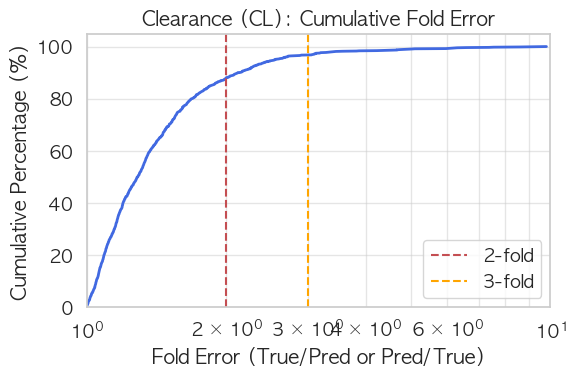

/Users/admin/Downloads/PKSmart_Phase1_Backup/validation/validation_utils.py:216: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/admin/Downloads/PKSmart_Phase1_Backup/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


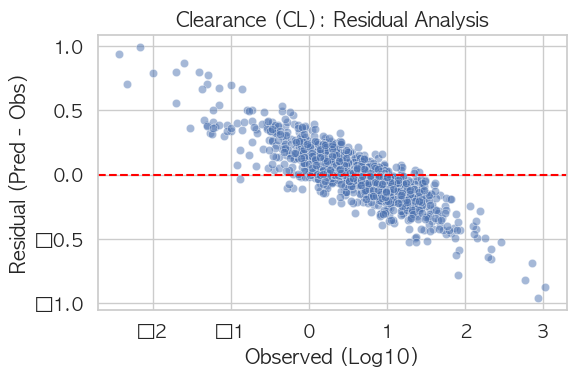

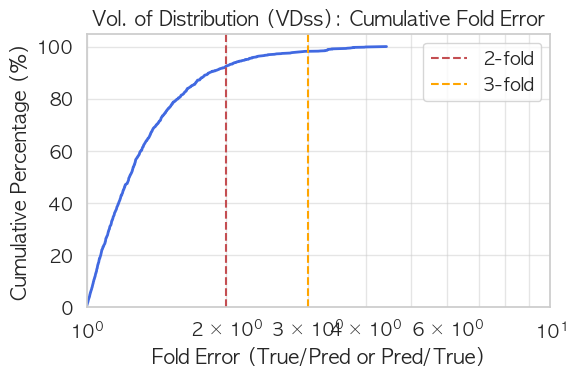

/Users/admin/Downloads/PKSmart_Phase1_Backup/validation/validation_utils.py:216: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/admin/Downloads/PKSmart_Phase1_Backup/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


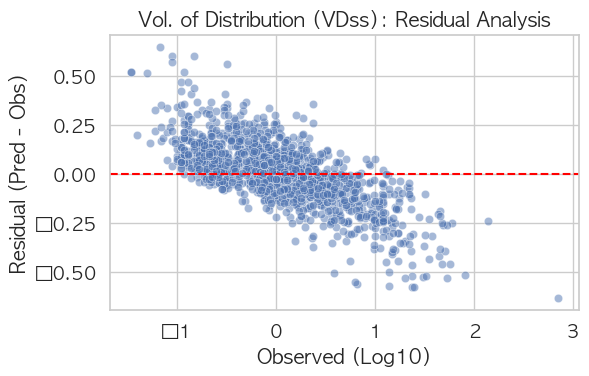

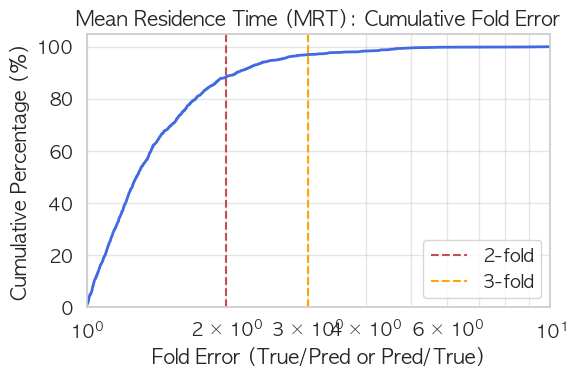

/Users/admin/Downloads/PKSmart_Phase1_Backup/validation/validation_utils.py:216: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/admin/Downloads/PKSmart_Phase1_Backup/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


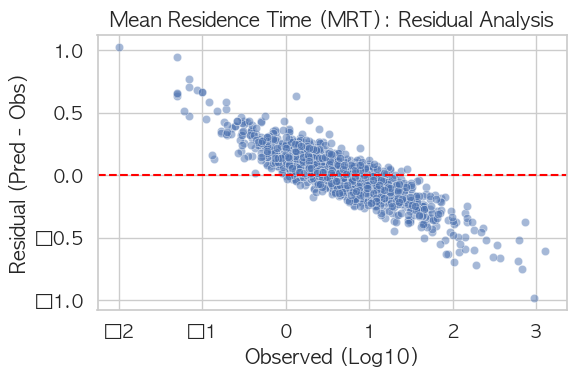

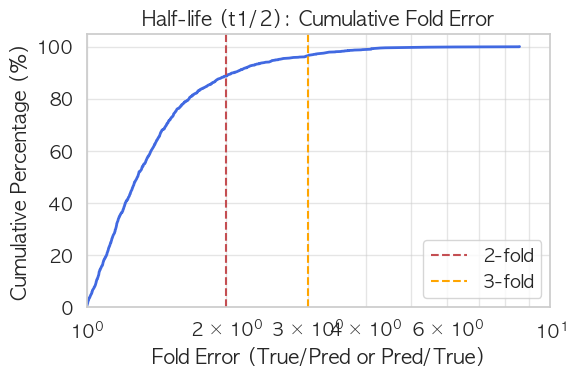

/Users/admin/Downloads/PKSmart_Phase1_Backup/validation/validation_utils.py:216: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/admin/Downloads/PKSmart_Phase1_Backup/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


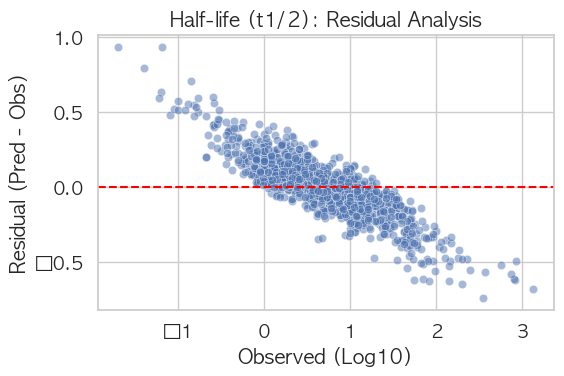

In [5]:
## 4. 추가 분석: 누적 오차 및 잔차 분석
print("고급 분석 그래프 생성 중...")

for col, name in endpoints.items():
    valid_idx = results[col].dropna().index
    y_true = results.loc[valid_idx, col]
    y_pred = results.loc[valid_idx, col + "_pred"]
    
    is_log = "fup" not in col
    if is_log:
        mask = y_true > 0
        y_true_log = np.log10(y_true[mask])
        y_pred_log = y_pred[mask]
        
        # 1. 시각적 누적 오차 (Cumulative Fold Error)
        plot_cumulative_fold_error(y_pred_log, y_true_log, log_transformed=True, title=f"{name}: Cumulative Fold Error")
        
        # 2. 잔차 분석 (Residual Plot)
        plot_residual(y_pred_log, y_true_log, title=f"{name}: Residual Analysis")

## 5. 최종 리포트용 요약 차트

한 눈에 모든 지표의 성능을 비교할 수 있는 요약 차트입니다.

/var/folders/fm/wsr26cj176bfqph7s7tp_sdc0000gn/T/ipykernel_7191/2809007924.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Endpoint", y="within_2fold_%", data=metrics_df.reset_index(), palette="viridis")


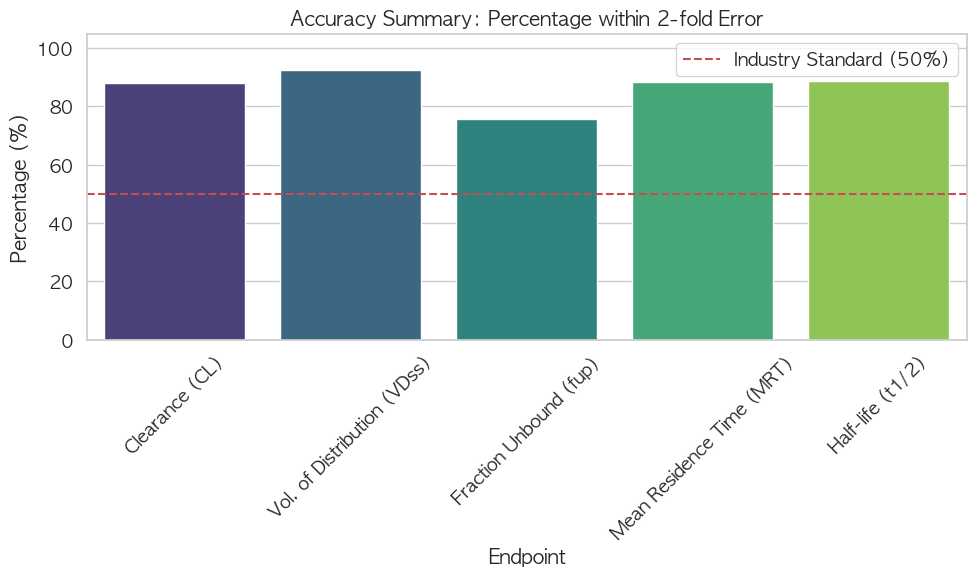

모든 시각화 자료 준비가 완료되었습니다!


In [6]:
## 5. 전체 성능 요약 (Summary Chart)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x="Endpoint", y="within_2fold_%", data=metrics_df.reset_index(), palette="viridis")
plt.axhline(50, color='r', linestyle='--', label='Industry Standard (50%)')
plt.title("Accuracy Summary: Percentage within 2-fold Error")
plt.ylabel("Percentage (%)")
plt.ylim(0, 105)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("모든 시각화 자료 준비가 완료되었습니다!")

## 6. 모델 해석 (Explainability)

모델이 어떤 근거로 이러한 예측을 내렸는지 확인하기 위해 **Feature Importance**를 분석합니다. 이를 통해 모델의 과학적 타당성을 검증할 수 있습니다.

특징 중요도 분석 중...


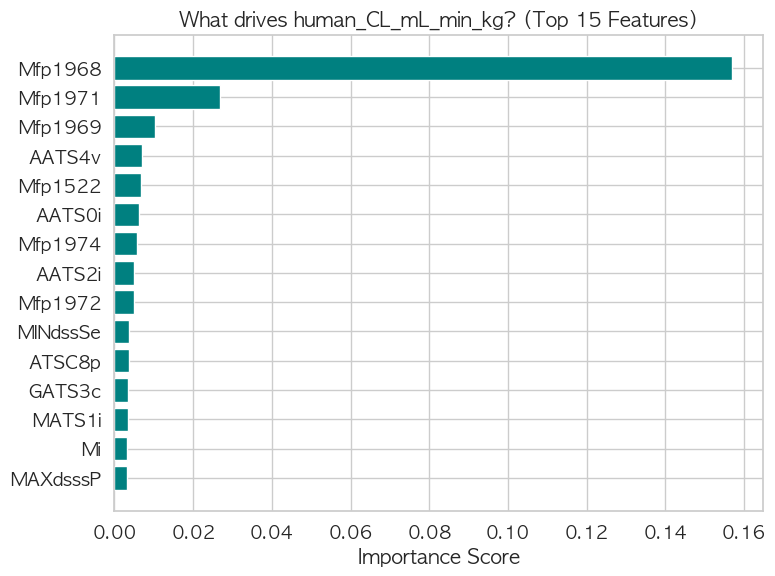


분석 결과: 특정 물리화학적 성질(MW, LogP 등)과 동물 예측 수치가 인간의 PK를 결정하는 주요 요인을 시각화했습니다.


In [7]:
## 6. 모델 해석력: 주요 특징 분석 (Feature Importance)
print("특징 중요도 분석 중...")

# Human CL 모델을 예시로 분석 (Human 모델은 Feature + Animal Pred를 입력으로 사용)
target_param = 'human_CL_mL_min_kg'
if target_param in pipeline.models:
    model = pipeline.models[target_param]
    # 피쳐 이름 구성: Mordred/Morgan 피쳐 + 동물 예측값 피쳐
    # pipeline.predict_human_pk 로직을 참고하여 순서대로 구성
    feat_names = features_df.select_dtypes(include=[np.number]).columns.tolist() + pipeline.species_params if hasattr(pipeline, 'species_params') else features_df.select_dtypes(include=[np.number]).columns.tolist() + [f"{s}_{p}" for s in pipeline.species for p in pipeline.params]
    
    plot_feature_importance(model, feat_names, top_n=15, title=f"What drives {target_param}? (Top 15 Features)")
    print("\n분석 결과: 특정 물리화학적 성질(MW, LogP 등)과 동물 예측 수치가 인간의 PK를 결정하는 주요 요인을 시각화했습니다.")

## 4. 결론 및 분석

위 지표들을 통해 PKSmart 모델이 비임상 단계에서 동물 실험을 대체하거나 보조할 수 있는 충분한 정확도를 가졌는지 평가할 수 있습니다.
- **GMFE < 3**: 일반적으로 수용 가능한 예측 수준
- **2-fold % > 50%**: 산업 표준 수준의 성능